In [1]:
from torch import optim
import torch.utils.data as data
from setting_model import *
import numpy as np
import os

CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
# Model instantiation
# forward_model = model
forward_model = FC_inverse_Net().to(device)

iteration = 0
interval = 100
batch_size = 100
lr = 3e-4
epoch = 5000
iter_num = []
losses = {'err_train': [], 'err_test': [], 'loss_train': [], 'loss_test': []}

In [3]:
# Gets the relevant file path
data_root = os.getcwd()
bo_len_path = os.path.join(data_root, "Train_Data", "X.csv")
assert os.path.exists(bo_len_path), "{} path does not exist.".format(bo_len_path)                  # assert function

train_spectrum_path = os.path.join(data_root, "Train_Data", "Fx_11696.csv")
assert os.path.exists(train_spectrum_path), "{} path does not exist.".format(train_spectrum_path)

test_spectrum_path = os.path.join(data_root, "Train_Data", "Fx_1300.csv")
assert os.path.exists(test_spectrum_path), "{} path does not exist.".format(test_spectrum_path)

# Save the updated weights file
#save_dir = os.path.join(data_root, "weight_optim")
#assert os.path.exists(save_dir), "{} path does not exist.".format(save_dir)

In [4]:
# Loader Data
train_numpy = np.loadtxt(train_spectrum_path, delimiter=",")
train_input = torch.FloatTensor(train_numpy[:, 0:300]).to(device)
train_label = torch.FloatTensor(train_numpy[:, 300:304]).to(device)
train_dataset = data.TensorDataset(train_input, train_label)
data_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)    # 提取训练数据集并加载

test_numpy = np.loadtxt(test_spectrum_path, delimiter=",")
test_input = torch.FloatTensor(test_numpy[:, 0:300]).to(device)
test_label = torch.FloatTensor(test_numpy[:, 300:304]).to(device)                               # 提取测试数据集

In [5]:
train_input.shape, test_input.shape

(torch.Size([11696, 300]), torch.Size([1300, 300]))

In [6]:
# Training process
def train():
    optimizer = optim.Adam(forward_model.parameters(), lr=lr)
    criterion = nn.MSELoss(reduction='mean')

    for t in range(epoch):
        for step, item in enumerate(data_loader):
            # train
            train_input, train_label = item
            train_predict = forward_model(train_input)
            loss_train = criterion(train_predict, train_label)
            
            global iteration                      # 声明全局变量， 不声明全局变量会报错
            if iteration % interval == 0:
                # test
                test_predict = forward_model(test_input)
                loss_test = criterion(test_predict, test_label)
                losses['loss_train'].append(loss_train.cpu().detach().numpy())
                losses['loss_test'].append(loss_test.cpu().detach().numpy())

                # compute and print the absolute error
                train_out = train_predict - train_label
                train_error = np.abs(train_out.cpu().detach().numpy()).mean()
                test_out = test_predict - test_label
                test_error = np.abs(test_out.cpu().detach().numpy()).mean()
                losses['err_train'].append(train_error)
                losses['err_test'].append(test_error)

                print('iteration: {}'.format(iteration))
                print('train_loss: {:.4}, test_loss: {:.4}'.
                      format(loss_train, loss_test))
                print('train_error: {:.4}, test_error: {:.4}'.
                      format(train_error, test_error))

                iter_num.append(iteration)


            # update parameters
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            iteration += 1

In [7]:
train()

iteration: 0
train_loss: 15.26, test_loss: 14.42
train_error: 3.241, test_error: 3.104
iteration: 100
train_loss: 2.114, test_loss: 1.781
train_error: 0.964, test_error: 0.9259
iteration: 200
train_loss: 1.57, test_loss: 1.467
train_error: 0.8324, test_error: 0.8137
iteration: 300
train_loss: 1.377, test_loss: 1.414
train_error: 0.8106, test_error: 0.8063
iteration: 400
train_loss: 1.489, test_loss: 1.288
train_error: 0.8531, test_error: 0.755
iteration: 500
train_loss: 1.166, test_loss: 1.221
train_error: 0.7204, test_error: 0.7284
iteration: 600
train_loss: 0.9515, test_loss: 1.116
train_error: 0.6572, test_error: 0.7004
iteration: 700
train_loss: 1.137, test_loss: 1.006
train_error: 0.7011, test_error: 0.65
iteration: 800
train_loss: 0.9856, test_loss: 0.9247
train_error: 0.6213, test_error: 0.6126
iteration: 900
train_loss: 1.184, test_loss: 0.8717
train_error: 0.6768, test_error: 0.5898
iteration: 1000
train_loss: 1.077, test_loss: 0.8074
train_error: 0.6895, test_error: 0.5904
it

KeyboardInterrupt: 

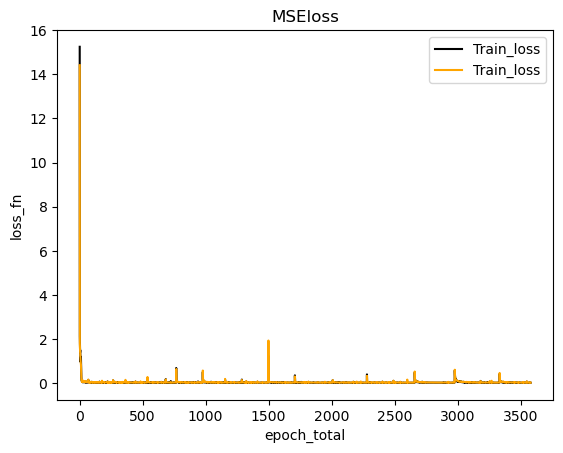

In [8]:
# 过拟合
# MSEloss curve
Len = len(losses['loss_train'])
epoch_total = np.linspace(0, Len, Len)
plt.title('MSEloss')
plt.plot(epoch_total, losses['loss_train'],color="black", label='Train_loss')
plt.plot(epoch_total, losses['loss_test'],color="orange", label='Train_loss')
plt.legend(loc='upper right')
plt.xlabel('epoch_total')
plt.ylabel('loss_fn')
plt.show()

In [16]:
# 训练集反向预测
c = 77
valid_input = train_input[c:c+1]
valid_predict = forward_model(valid_input).view(-1).cpu().detach().numpy().reshape(1, 4)
valid_label = train_label[c].cpu().detach().numpy().reshape(1, 4)
valid_predict = valid_predict.reshape(4,)
valid_label = valid_label.reshape(4,)
valid_predict, valid_label

(array([1.49483  , 1.4892488, 4.0188036, 2.0160012], dtype=float32),
 array([1.5, 1.5, 4. , 2. ], dtype=float32))

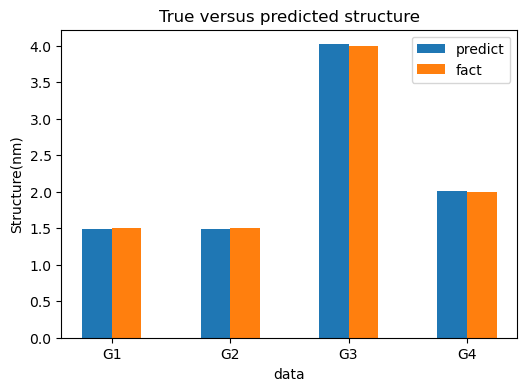

In [17]:
plt.figure(figsize=(20, 4))
labels = ['G1', 'G2', 'G3', 'G4']

# 两组数据
plt.subplot(131)
x = np.arange(len(labels))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, valid_predict, width, label='predict')
plt.bar(x + width/2, valid_label, width, label='fact')
plt.xlabel('data')
plt.ylabel('Structure(nm)')
plt.title('True versus predicted structure')

# x轴刻度标签位置不进行计算
plt.xticks(x, labels=labels)
plt.legend()

In [23]:
# 测试集预测
c = 925
valid_input = test_input[c:c+1]
valid_predict = forward_model(valid_input).view(-1).cpu().detach().numpy().reshape(1, 4)
valid_label = test_label[c].cpu().detach().numpy().reshape(1, 4)
valid_predict = valid_predict.reshape(4,)
valid_label = valid_label.reshape(4,)
for i in range(4):
    if valid_predict[i] <= 0:
        valid_predict[i] = 0

valid_label, valid_predict

(array([1.5, 1. , 1. , 5. ], dtype=float32),
 array([1.487231 , 1.0080738, 1.0073297, 4.990888 ], dtype=float32))

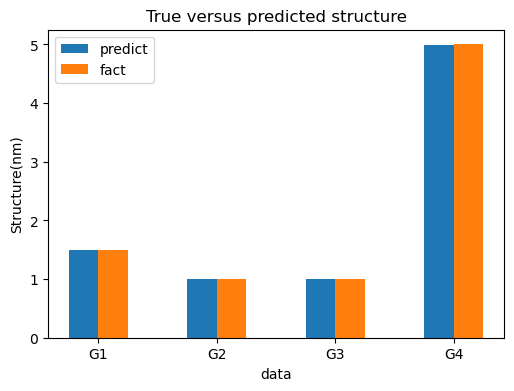

In [24]:
plt.figure(figsize=(20, 4))
labels = ['G1', 'G2', 'G3', 'G4']

# 两组数据
plt.subplot(131)
x = np.arange(len(labels))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, valid_predict, width, label='predict')
plt.bar(x + width/2, valid_label, width, label='fact')
plt.xlabel('data')
plt.ylabel('Structure(nm)')
plt.title('True versus predicted structure')

# x轴刻度标签位置不进行计算
plt.xticks(x, labels=labels)
plt.legend()

In [15]:
# Save the updated weights file
save_dir = os.path.join(data_root, "weight_optim")
assert os.path.exists(save_dir), "{} path does not exist.".format(save_dir)

# Save the weight_optim
torch.save(forward_model, save_dir + '\inverse_test_Fx_1300_FC'  + '.pth')# Save the weight_optim

[1.725 9.5   1.    4.   ] [1.6639894 9.448406  0.9025339 4.1095924]


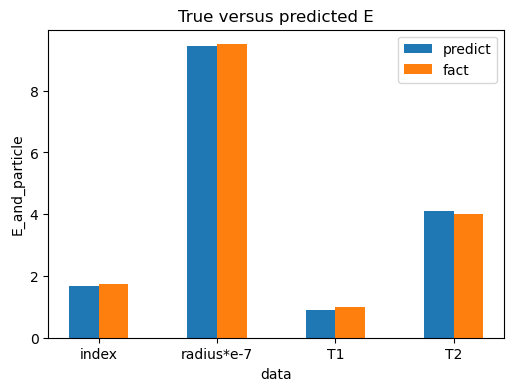

In [34]:
# 加载预测权重
forward_model = torch.load(save_dir + '\inverse_test_Fx_1300_FC'  + '.pth')
# 测试集预测
c = 33
valid_input = test_input[c:c+1]
valid_predict = forward_model(valid_input).view(-1).cpu().detach().numpy().reshape(1, 4)
valid_label = test_label[c].cpu().detach().numpy().reshape(1, 4)
valid_predict = valid_predict.reshape(4,)
valid_label = valid_label.reshape(4,)
for i in range(4):
    if valid_predict[i] <= 0:
        valid_predict[i] = 0

print(valid_label, valid_predict)

plt.figure(figsize=(20, 4))
labels = ['index', 'radius*e-7', 'T1', 'T2']

# 两组数据
plt.subplot(131)
x = np.arange(len(labels))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, valid_predict, width, label='predict')
plt.bar(x + width/2, valid_label, width, label='fact')
plt.xlabel('data')
plt.ylabel('E_and_particle')
plt.title('True versus predicted E')

# x轴刻度标签位置不进行计算
plt.xticks(x, labels=labels)
plt.legend()